# Welcome to the QICK lab day 1 at the 2024 QIS Summer School!

### Day 1 agenda:
* Introducing our teaching team and welcoming you to the labs (~30 minutes)
* QubitControl notebook ("Show and Tell" style) (~45 min)
* Resonator notebook (More hands on work for you) (~45 min)

### Day 2 agenda:
* Discussion of superconducting qubit control pulse sequences (especially how to measure qubit T1) (~30 minutes)
* QubitReadout notebook (More hands on work for you) (~90 min)

```diff
+ Throughout both lab days, we will be asking you questions in green font! Please answer them in a new cell below the question.
```

# RF superconducting resonators 101

This example shows a basic demonstration of reading out the transmission data from emulated superconducting resonators and fitting that data.

Then we move on to showing how the resonator can jump from one frequency to the other, emulating a qubit undergoing energy relaxation (T1 decay).

In [1]:
# pip install seaborn

In [2]:
import sys
# sys.path.append('../qick/qick_lib/')
sys.path.append('../soft/')
sys.path.append('../firmware/')

from hist_analysis import *
from qick import *
from qick_training import *

from qick.averager_program import QickSweep
from qick.averager_program import QickRegister
from qick.averager_program import merge_sweeps

from numpy.fft import fft, fftshift
from random import *
from scipy.optimize import curve_fit
from scipy.stats import cauchy

# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)
# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSweep1D

In [3]:
from qick_training import *

soc = QickTrainingSoc(bitfile="../fw/2024-09-12_216_tprocv2r21_kidsim/qick_216.bit")

soccfg = soc
print(soccfg)

QICK running on ZCU216, software version 0.2.283

Firmware configuration (built Thu Sep 12 15:54:16 2024):

	Global clocks (MHz): tProcessor 614.400, RF reference 245.760

	1 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 16384 samples (1.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3

	2 readout channels:
	0:	axis_dyn_readout_v1 - configured by tProc output 1
		fs=2457.600 MHz, decimated=307.200 MHz, 32-bit DDS, range=2457.600 MHz
		maxlen 16384 accumulated, 65536 decimated (213.333 us)
		triggered by tport 0, pin 0, feedback to tProc input 0
		ADC tile 2, blk 0 is 0_226, on JHC7
	1:	axis_readout_v2 - configured by PYNQ
		fs=2457.600 MHz, decimated=307.200 MHz, 32-bit DDS, range=2457.600 MHz
		maxlen 16384 accumulated, 65536 decimated (213.333 us)
		triggered by tport 1, pin 0, feedback to tProc input 1
		ADC tile 2, blk 1 is 1_226, on JHC8

	16 digital output pins:
	0:	PMOD0_0_LS
	1:	PMOD0_1_LS


In [4]:
GEN_CH = 0
RO_CH = 0

# RF superconducting resonator 101

# Why are superconducting resonators important?

* 1. You can use them to read out superconducting qubits in a way that does not destroy the quantum state of the qubit (quantum nondemolition readout), like we talked about in this morning's lecture. 
    * Our reference from lecture: https://arxiv.org/abs/2106.06173 
    
* 2. You can also do things the other way around, and use a superconducting qubit to read out the resonator, and store the quantum information in the resonator instead. 
    * This is used to search for axion dark matter, which is a useful practical application of today's noisy superconducting qubits: https://arxiv.org/abs/2008.12231
    
* 3. You can fabricate high-quality-factor resonators to learn about how to fabricate low-loss superconducting films and therefore you can learn how to make better films for your qubits (which are more complicated to fabricate).
    * There are many papers about this, for example https://arxiv.org/pdf/2211.16437 

```diff
+ Q: Take a few minutes to review the concept of dispersive readout with your group/TA.
```
See Figure 3 of https://arxiv.org/pdf/2106.06173 which we talked about in the morning's lecture.

# Set up your resonator

This resonator's frequency is 500 MHz. The resonator has a certain quality factor, which you will extract by fitting it in a cell below.

### Note: this is not a real resonator, so there’s some slight differences. A resonator represented as a transfer function can made with a pole and a zero of a complex function (the coefficients c0 and c1 are the location of the zero and the pole.)

* Here's a reference about this, but this is outside the scope of our lab: https://brianmcfee.net/dstbook-site/content/ch12-ztransform/PoleZero.html 

```
Help on method config_resonator in module qick_training:

config_resonator(simu_ch=0, q_adc=6, q_dac=0, f=500.0, df=2.0, dt=10.0, c0=0.99, c1=0.8, verbose=False) method of qick_training.QickTrainingSoc instance
    Configure the resonator simulator.
    
    The two qout values truncate the data at different points in the simulator.
    They affect both the simulator gain and its dynamic range.
    Smaller values mean more gain, but you might saturate something and your decimated traces will look like garbage.
    The default values were chosen to avoid saturation at max pulse power (i.e. a gain-1 const pulse).
    
    Parameters
    ----------
    simu_ch : int
        index of the simulator you want to configure
    q_adc : int
        number of bits to truncate at simulator input
        this basically sets the input's dynamic range
    q_dac : int
        number of bits to truncate at simulator output
        this basically sets the output power
    f : float
        resting frequency of the resonator, in MHz
    df : float
        size of the frequency jump, in MHz
        after the jump, the resonator freq will be f-df
    dt : float
        jump duration, in us
        the resonator will jump back to its rest state after this time
    c0 : float
        resonator parameter, in the range 0.0 - 1.0
        roughly speaking, this sets the width scale of the resonator
    c1 : float
        resonator parameter, in the range 0.0 - c0
        roughly speaking, this sets the depth of the resonator minimum
```

```diff
+ Q: Take a few minutes to review the above parameters of your resonator that you will configure.
```

In [5]:
soc.config_resonator(c0=0.85, c1=0.8, verbose=True)

SimuChain: f = 500.0 MHz, fd = -114.39999999999998 MHz, k = 232, fdds = 0.8000000000000114 MHz
AxisKidsimV3: sel        = resonator
AxisKidsimV3: channel    = 232
AxisKidsimV3: lane       = 0
AxisKidsimV3: punct_id   = 29
AxisKidsimV3: iir_c0     = 0.85
AxisKidsimV3: iir_c1     = 0.8
AxisKidsimV3: iir_g      = 0.9729729729729729
AxisKidsimV3: dds_freq   = 0.8000000000000114
AxisKidsimV3: dds_wait   = 95
AxisKidsimV3: sweep_freq = 2.0
AxisKidsimV3: sweep_time = 10.0
AxisKidsimV3: nstep      = 1
freq = 5461, bval = 13653, slope = 13653, steps = 1, wait = 95
c0 = 27853, c1 = 26214, g = 31882
sel = 0, punct_id = 29, addr = 0


In [6]:
class FreqSweepProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_loop("myloop", self.cfg["steps"])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
#                        style="flat_top", 
                       style="const", 
#                        envelope="ramp",
                       freq=cfg['freq'], 
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
#         self.trigger(pins=list(range(8,16)),t=0)
        
    def _body(self, cfg):
        # if you delay the config by too long, you can see the readout get reconfigured in the middle of your pulse
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])


# Resonator spectroscopy

By measuring the complex S_21 of the resonator around its resonant frequency, we can find its resonance and then fit it to find its quality factor. Let's measure this S_21 of our resonator.

But first, we will measure the cable delay across the resonance, so we can calibrate it away:

We can estimate the amount of cable delay we'd expect, for example, 100m of coaxial cable will provide a delay of about:

 $\Delta t = (100 m)/(80\% * 3*10^8 m/s) = 0.4 \mu s$
 
if we assume that the propagation in the cable is 80% the speed of light.

* If the input signal has a frequency of 250kHz, its period is 4µs. Therefore, a delay of 0.4µs causes a phase shift of 1/10 of a period, or 360 degrees /10 = 36 degrees. 
* But if the signal frequency is 500kHz, its period is 2µs, and now a 0.4µs delay causes a phase shift of 1/5 of a period, or 360 degrees /5 = 72 degrees.

See this article for more details about this example: https://circuitcellar.com/research-design-hub/group-delay-basics-more-filter-fun/

In [7]:
START_FREQ = 495
CAL_RANGE = 0.1
END_FREQ = 505


# do a sweep with 5 points and plot decimated
config = {'steps': 5,
          'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': QickSweep1D("myloop", START_FREQ, START_FREQ+CAL_RANGE),
          'nqz': 1,
          'trig_time': 3.0,
          'ro_len': 7,
          'flat_len': 5.0,
          'phase': 0,
          'gain': 1.0,
         }

  0%|          | 0/10010 [00:00<?, ?it/s]

phase step (cycles): -8.459532481686072e-05
relative delay -0.8073 us


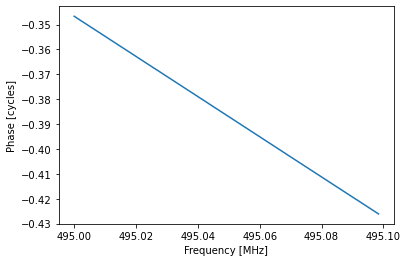

In [8]:
# config['steps']=100001
config['steps']=1001

prog = FreqSweepProgram(soccfg, reps=10, final_delay=1.0, cfg=config)
freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
iq_list = prog.acquire(soc, soft_avgs=1, progress=True)
# plt.plot(np.angle(iq_list[0][0].dot([1,1j]), deg=True))

# plt.plot(iq_list[0][0,:,0], iq_list[0][0,:,1], '.')
# plt.ylabel("Q [ADU]")
# plt.xlabel("I [ADU]");

iq_complex = iq_list[0][0].dot([1,1j])
phases = np.unwrap(np.angle(iq_complex))/(2*np.pi)

plt.plot(freqs, phases)
plt.ylabel("Phase [cycles]")
plt.xlabel("Frequency [MHz]")

print("phase step (cycles):", phases[1]-phases[0])

a = np.vstack([freqs, np.ones_like(freqs)]).T
phase_delay = np.linalg.lstsq(a, phases, rcond=None)[0][0]
print("relative delay %.4f us"%(phase_delay))

```diff
+ Q: Why does cable delay cause an overall slope to the phase?
```

Now we sweep the frequency about the resonance of our resonator.

In [9]:
config['freq'] = QickSweep1D("myloop", START_FREQ, END_FREQ)

config['steps'] = 10001

prog = FreqSweepProgram(soccfg, reps=10, final_delay=10.0, cfg=config)
freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
iq_list = prog.acquire(soc, soft_avgs=1, progress=True)
iq_complex = iq_list[0][0].dot([1,1j])

  0%|          | 0/100010 [00:00<?, ?it/s]

Now we rotate the IQ data to calibrate away the cable delay across the resonance, and plot the signal I and Q.

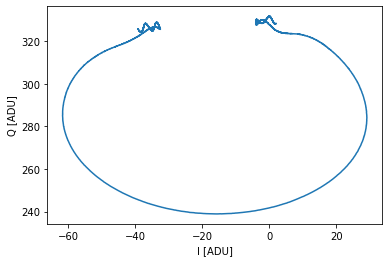

In [10]:
iq_rotated = iq_complex*np.exp(-1j*freqs*2*np.pi*phase_delay)

plt.plot(np.real(iq_rotated), np.imag(iq_rotated))
plt.ylabel("Q [ADU]")
plt.xlabel("I [ADU]");

```diff
+ Q: Why does a resonance look like a circle? 
```

For more information, see: https://arxiv.org/pdf/1410.3365

In [11]:
### Solution: When you factor in the line length to frequency ratio you get
### a circle for "flat transmission" as the phase winds. 

Finally we plot the signal amplitude and phase.

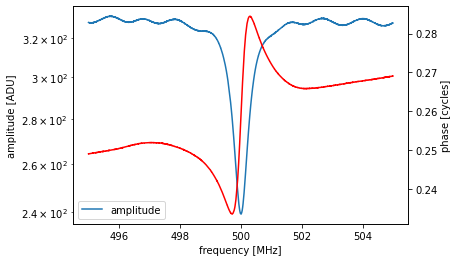

In [12]:
# phases_corrected = np.unwrap(np.angle(iq_rotated))/(2*np.pi)
phases_corrected = np.angle(iq_rotated)/(2*np.pi)

fig, plot = plt.subplots()
plot.semilogy(freqs, np.abs(iq_rotated), label="amplitude")
ax2 = plot.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(freqs, phases_corrected, color='red', label='phase')
plot.set_ylabel("amplitude [ADU]")
plot.set_xlabel("frequency [MHz]")
ax2.set_ylabel("phase [cycles]");
plot.legend()

```diff
+ Q: Why is there a phase discontinuity of the signal at its resonance? What physics-wise is happening here?
```

In [13]:
### Solution: Very roughly speaking, the signal gets "taken in" by the resonator. 
### E.g. it resonates inside the resonator
### and when it leaves it has a different phase.
### E.g. If resonator is in reflection, the signal bounces off resonator and leaves with a different phase.

### Another explanation: a single RF photon traveling down the feedline will hop into the resonator, 
### and spend a time there based on the resonator Q before being emitted back into the feedline. 
### When that photon leaves its going to have a different phase. (If you think of the resonator as 
### a ring that the photon is traveling around, then its like a path length difference - as a function 
### of frequency - that produces a phase shift)

Now we plot the amplitude in units of decibels (dB) as this is the S21 transmission signal that we want to fit.

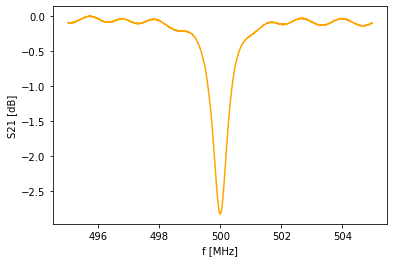

In [14]:
S21_r1 = np.real(20*np.log10(iq_rotated/np.max(np.abs(iq_rotated))))

#############
### Plots ###
#############
plt.plot(freqs,S21_r1,color='orange')
plt.xlabel('f [MHz]')
plt.ylabel('S21 [dB]');

In [15]:
# ## Save data (optional)
# import pickle
# saveDict = {'freqs': freqs, 'S21': S21, 'xi_v': xi_v, 'xq_v': xq_v}

# with open('resData_iq.pkl', 'wb') as handle:
#     pickle.dump(saveDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Let's fit this resonator and extract its quality factor. 

Q = f/kappa, where kappa is the linewidth of the resonator-- its full width at half maximum.

```diff
+ 1. Find the full width, half maximum (kappa) of the resonator, analytically. Then determine the quality factor of the resonator.
```

In [16]:
def lorentzian(f, gamma, f0, A):
    return A * (gamma/2) * (1/(1 + np.power((f-f0)/(gamma/2),2.)))

def FWHM_analytic(f, S21):
    # Find the minimum value and its index
    min_idx = np.argmin(S21)
    f_min = f[min_idx]
    S_min = S21[min_idx]
    # Calculate the half-maximum point
    halfmax = (np.max(S21) + S_min) / 2
    # Find the frequencies corresponding to the half-maximum points
    left_idx = np.argmin(np.abs(S21[:min_idx] - halfmax))
    right_idx = min_idx + np.argmin(np.abs(S21[min_idx:] - halfmax))
    hm_f_lo = f[left_idx]
    hm_f_hi = f[right_idx]
    # Calculate FWHM
    FWHM = abs(hm_f_hi - hm_f_lo)
    return f_min, S_min, FWHM


In [17]:
### Solution:

f_min , S_min, FWHM = FWHM_analytic(freqs, S21_r1)
print("center frequency:", f_min)
print("FWHM from straight calculation:", FWHM)

center frequency: 499.997607421875
FWHM from straight calculation: 0.5897735595702898


In [18]:
### Solution:
Q = f_min/FWHM
print("Resonator quality factor is ~" + str(int(Q)))

Resonator quality factor is ~847


```diff
+ 2. Fit the resonator to a Lorentzian using the scipy `curve_fit` function. Do so by zooming in to the center of your data to get a good fit (right around the resonance)

```

You will need to make a guess at the FWHM, the resonance frequency, and an overall factor corresponding to the amplitude of your resonator dip (see the Lorentzian function above).

center frequency: 499.995570351443
FWHM from fit: 0.5859103900030631
Gain factor from fit: -9.70072370740912


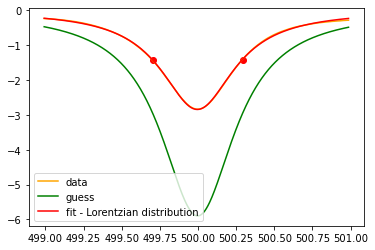

In [19]:
### Solution:

min_idx = 4000
max_idx = 6000

plt.scatter([f_min-FWHM/2.],[S_min/2.],color='r',marker='o')
plt.scatter([f_min+FWHM/2.],[S_min/2.],color='r',marker='o')

guess = [FWHM , f_min , -20]
gss_lorentzian = lorentzian(freqs, *guess)
popt, pcov = curve_fit(lorentzian, freqs[min_idx:max_idx], S21_r1[min_idx:max_idx], maxfev = 100000, p0 = guess)
fit_lorentzian = lorentzian(freqs, *popt)
plt.plot(freqs[min_idx:max_idx], S21_r1[min_idx:max_idx], color='orange', label="data")
plt.plot(freqs[min_idx:max_idx], gss_lorentzian[min_idx:max_idx], color='green', label="guess")
plt.plot(freqs[min_idx:max_idx], fit_lorentzian[min_idx:max_idx], color='red', label="fit - Lorentzian distribution")
plt.legend()

print("center frequency:", popt[1])
print("FWHM from fit:", popt[0])
print("Gain factor from fit:", popt[2])

```diff
+ 3. Use the linewidth you fitted to compute the quality factor of your resonator.

```

In [20]:
### Solution:

kappa_lorentzian_r1 = popt[0] ## Resonator linewidth (gamma of the Lorentzian function)
f_lorentzian_r1 = popt[1] ## Resonator center frequency
gain_factor_lorentzian_r1 = popt[2] ## Gain factor associated with Lorentzian function
Q_lorentzian_r1 = f_lorentzian_r1/kappa_lorentzian_r1
print("Resonator quality factor is ~" + str(int(Q_lorentzian_r1)))

Resonator quality factor is ~853


```diff
+ 4. Compare this quality factor to the quality factor of the readout resonator in the QICK paper: 

```
https://arxiv.org/abs/2110.00557 Figure 14

In [21]:
### Solution:

kappa = 1e6 ## Resonator linewidth from QICK paper
f = 8.5015e9 ## Resonator center frequency from QICK paper
Q = f/kappa
print("Resonator quality factor is ~" + str(int(Q)))

Resonator quality factor is ~8501


### Note: As we mentioned above, this is not a real resonator, so there’s some slight differences. A resonator represented as a transfer function can made with a pole and a zero of a complex function (the coefficients c0 and c1 are the location of the zero and the pole.) Let's learn about what changing these coefficients do.

In [22]:
def polezero(f, f0, c0, c1, G):
    z = np.exp(1j*f)
    # apply an overall G0 = (1+c1)/(1+c0) which seems to normalize to 1 far from the resonance
    G0 = (1+c1)/(1+c0)
    return G*G0*np.abs((z-c0*np.exp(1j*f0))/(z-c1*np.exp(1j*f0)))

### Varying coefficient c0 sets the depth of the minimum

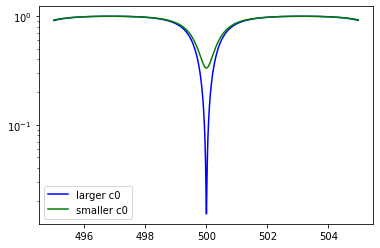

In [23]:
plt.semilogy(freqs, polezero(freqs, 500, 0.99, 0.5, 1.0), label='larger c0',color='blue')
plt.semilogy(freqs, polezero(freqs, 500, 0.8, 0.5, 1.0),label='smaller c0',color='green')
plt.legend()

### Varying coefficient c1 sets the width scale

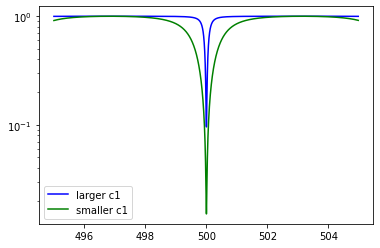

In [24]:
plt.semilogy(freqs, polezero(freqs, 500, 0.99, 0.9, 1.0), label='larger c1',color='blue')
plt.semilogy(freqs, polezero(freqs, 500, 0.99, 0.5, 1.0), label='smaller c1',color='green')
plt.legend()

### To lower the resonator's quality factor, lower c0, and then choose c1 < c0

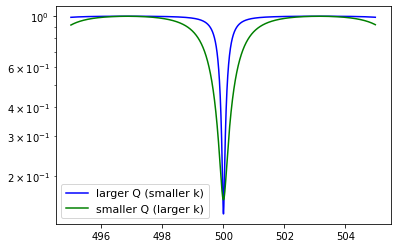

In [25]:
plt.semilogy(freqs, polezero(freqs, 500, 0.97, 0.8, 1.0), label='larger Q (smaller k)',color='blue')
plt.semilogy(freqs, polezero(freqs, 500, 0.9, 0.5, 1.0),label='smaller Q (larger k)',color='green')
plt.legend(loc='lower left', prop={'size': 11})

# Let's fit a different resonator now

In [26]:
soc.config_resonator(c0=0.8, c1=0.4, verbose=True)

SimuChain: f = 500.0 MHz, fd = -114.39999999999998 MHz, k = 232, fdds = 0.8000000000000114 MHz
AxisKidsimV3: sel        = resonator
AxisKidsimV3: channel    = 232
AxisKidsimV3: lane       = 0
AxisKidsimV3: punct_id   = 29
AxisKidsimV3: iir_c0     = 0.8
AxisKidsimV3: iir_c1     = 0.4
AxisKidsimV3: iir_g      = 0.7777777777777777
AxisKidsimV3: dds_freq   = 0.8000000000000114
AxisKidsimV3: dds_wait   = 95
AxisKidsimV3: sweep_freq = 2.0
AxisKidsimV3: sweep_time = 10.0
AxisKidsimV3: nstep      = 1
freq = 5461, bval = 13653, slope = 13653, steps = 1, wait = 95
c0 = 26214, c1 = 13107, g = 25486
sel = 0, punct_id = 29, addr = 0


# Resonator spectroscopy

By measuring the complex S_21 of the resonator around its resonant frequency, we can find its resonance and then fit it to find its quality factor. Let's measure this S_21 of our resonator.

In [27]:
START_FREQ = 495
CAL_RANGE = 0.1
END_FREQ = 505


# do a sweep with 5 points and plot decimated
config = {'steps': 5,
          'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': QickSweep1D("myloop", START_FREQ, START_FREQ+CAL_RANGE),
          'nqz': 1,
          'trig_time': 3.0,
          'ro_len': 7,
          'flat_len': 5.0,
          'phase': 0,
          'gain': 1.0,
         }

  0%|          | 0/10010 [00:00<?, ?it/s]

phase step (cycles): -6.27432370719494e-05
relative delay -0.8071 us


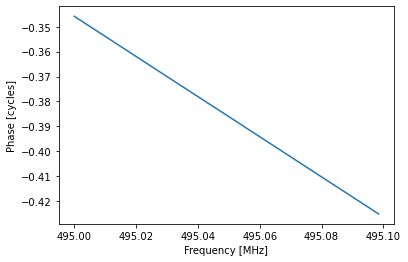

In [28]:
# config['steps']=100001
config['steps']=1001

prog = FreqSweepProgram(soccfg, reps=10, final_delay=1.0, cfg=config)
freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
iq_list = prog.acquire(soc, soft_avgs=1, progress=True)
# plt.plot(np.angle(iq_list[0][0].dot([1,1j]), deg=True))

# plt.plot(iq_list[0][0,:,0], iq_list[0][0,:,1], '.')
# plt.ylabel("Q [ADU]")
# plt.xlabel("I [ADU]");

iq_complex = iq_list[0][0].dot([1,1j])
phases = np.unwrap(np.angle(iq_complex))/(2*np.pi)

plt.plot(freqs, phases)
plt.ylabel("Phase [cycles]")
plt.xlabel("Frequency [MHz]")

print("phase step (cycles):", phases[1]-phases[0])

a = np.vstack([freqs, np.ones_like(freqs)]).T
phase_delay = np.linalg.lstsq(a, phases, rcond=None)[0][0]
print("relative delay %.4f us"%(phase_delay))

Now we sweep the frequency about the resonance of our resonator.

In [29]:
config['freq'] = QickSweep1D("myloop", START_FREQ, END_FREQ)

config['steps'] = 10001

prog = FreqSweepProgram(soccfg, reps=10, final_delay=10.0, cfg=config)
freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
iq_list = prog.acquire(soc, soft_avgs=1, progress=True)
iq_complex = iq_list[0][0].dot([1,1j])

  0%|          | 0/100010 [00:00<?, ?it/s]

Now we rotate the IQ data to calibrate away the cable delay across the resonance, and plot the signal amplitude and phase.

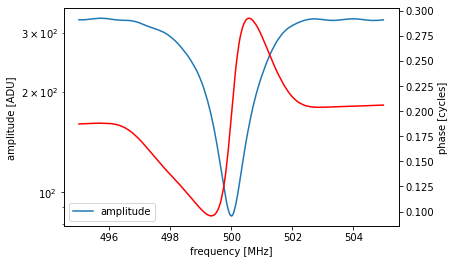

In [30]:
iq_rotated = iq_complex*np.exp(-1j*freqs*2*np.pi*phase_delay)
# phases_corrected = np.unwrap(np.angle(iq_rotated))/(2*np.pi)
phases_corrected = np.angle(iq_rotated)/(2*np.pi)

fig, plot = plt.subplots()
plot.semilogy(freqs, np.abs(iq_rotated), label="amplitude")
ax2 = plot.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(freqs, phases_corrected, color='red', label='phase')
plot.set_ylabel("amplitude [ADU]")
plot.set_xlabel("frequency [MHz]")
ax2.set_ylabel("phase [cycles]");
plot.legend()

Now we plot the amplitude in units of decibels (dB) as this is the S21 transmission signal that we want to fit.

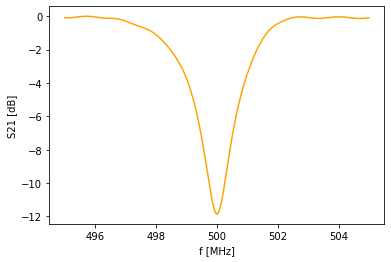

In [31]:
S21_r2 = np.real(20*np.log10(iq_rotated/np.max(np.abs(iq_rotated))))

#############
### Plots ###
#############
plt.plot(freqs,S21_r2,color='orange')
plt.xlabel('f [MHz]')
plt.ylabel('S21 [dB]');

### Let's fit this resonator and extract its quality factor. 

Q = f/kappa, where kappa is the linewidth of the resonator-- its full width at half maximum.

```diff
+ 1. Find the full width, half maximum (kappa) of the resonator, analytically. Then determine the quality factor of the resonator.
```

In [32]:
### Solution:

f_min , S_min, FWHM = FWHM_analytic(freqs, S21_r2)
print("center frequency:", f_min)
print("FWHM from straight calculation:", FWHM)

center frequency: 500.00159912109376
FWHM from straight calculation: 1.2843292236328239


```diff
+ 2. Fit the resonator to a Lorentzian using the scipy `curve_fit` function. Do so by zooming in to the center of your data to get a good fit (right around the resonance)

```
You will need to make a guess at the FWHM, the resonance frequency, and an overall factor corresponding to the amplitude of your resonator dip (see the Lorentzian function above).

center frequency: 499.98461687884134
FWHM from fit: 1.2850094431112822
Gain factor from fit: -18.22773162238936


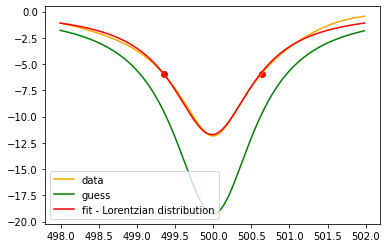

In [33]:
### Solution:

min_idx = 3000
max_idx = 7000

plt.scatter([f_min-FWHM/2.],[S_min/2.],color='r',marker='o')
plt.scatter([f_min+FWHM/2.],[S_min/2.],color='r',marker='o')

guess = [FWHM , f_min , -30]
gss_lorentzian = lorentzian(freqs, *guess)
popt, pcov = curve_fit(lorentzian, freqs[min_idx:max_idx], S21_r2[min_idx:max_idx], maxfev = 100000, p0 = guess)
fit_lorentzian = lorentzian(freqs, *popt)
plt.plot(freqs[min_idx:max_idx], S21_r2[min_idx:max_idx], color='orange', label="data")
plt.plot(freqs[min_idx:max_idx], gss_lorentzian[min_idx:max_idx], color='green', label="guess")
plt.plot(freqs[min_idx:max_idx], fit_lorentzian[min_idx:max_idx], color='red', label="fit - Lorentzian distribution")
plt.legend()

print("center frequency:", popt[1])
print("FWHM from fit:", popt[0])
print("Gain factor from fit:", popt[2])

```diff
+ 3. Use the linewidth you fitted to compute the quality factor of your resonator.

```

In [34]:
### Solution:

kappa_lorentzian_r2 = popt[0] ## Resonator linewidth (gamma of the Lorentzian function)
f_lorentzian_r2 = popt[1] ## Resonator center frequency
gain_factor_lorentzian_r2 = popt[2] ## Gain factor associated with Lorentzian function
Q_lorentzian_r2 = f_lorentzian_r2/kappa_lorentzian_r2
print("Resonator quality factor is ~" + str(int(Q_lorentzian_r2)))

Resonator quality factor is ~389


# Overlaying a fit to the resonator to visualize its transfer function S21

Plot functions credit to Professor Alex Ma: https://colab.research.google.com/drive/1sLLlLYMNsGkx8GDkBFPCNZmclJiPkWvr?usp=sharing#scrollTo=TNvM-OswNped 

Ma lab website: https://www.ma-quantumlab.com/ 

In [35]:
%matplotlib inline
import matplotlib.image as mpimg
from matplotlib.pyplot import *
from scipy import *
from numpy import *
import time

from matplotlib.pyplot import *
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

from ipywidgets import interactive, fixed
import ipywidgets as widgets
from IPython.display import display

In [36]:
def plot_resonance(dw, Sdata, fmin, amp, freq_data, S21_data, label):
    dw_range = max(dw)
    figure(figsize=[15,9])
    ax = subplot(2,3,1); title("Abs "+label); plot(dw+fmin, abs(Sdata))
    ax.set_xlim(fmin-dw_range,fmin+dw_range); ax.set_ylim(0, 1.5)
    axhline(1.0, ls='--')
    ax.plot(freq_data, (-1/amp)*S21_data+1, label="data")
    ax.legend(loc='lower left', prop={'size': 10})
    
    ax = subplot(2,3,2); title("Arg "+label); plot(dw+fmin, angle(Sdata))
    ax.set_xlim(fmin-dw_range,fmin+dw_range); ax.set_ylim(-pi,pi)
    axhline(0.0, ls='--')

    ax = subplot(2,3,3); title("Complex "+label); plot(real(Sdata), imag(Sdata))
    ax.set_xlim(-1.05, 1.05); ax.set_ylim(-1.05, 1.5)
    axhline(0.0, ls='--'); axvline(0.0, ls='--')

    ax = subplot(2,3,4); title("Re "+label); plot(dw+fmin, real(Sdata))
    ax.set_xlim(fmin-dw_range,fmin+dw_range); ax.set_ylim(-1.5, 1.5)
    axhline(0.0, ls='--')

    ax = subplot(2,3,5); title("Im "+label); plot(dw+fmin, imag(Sdata))
    ax.set_xlim(fmin-dw_range,fmin+dw_range); ax.set_ylim(-1.5, 1.5)
    axhline(0.0, ls='--')

    show()

Source for the hanger equation: e.g. Equation 1 of https://arxiv.org/abs/0908.2948

In [37]:
def plotHanger(fmin, amp, freq_data, S21_data, df_range, k_inner, k_out):
      df = np.linspace(-df_range,df_range,1001)
      S21 = 1j*(1-k_out/(k_inner+2.0j*df+k_out))
      plot_resonance(df, S21, fmin, amp, freq_data, S21_data, label='S21')

In [38]:
interactive_plot = interactive(plotHanger, 
                               fmin=fixed(f_lorentzian_r2), amp=fixed(gain_factor_lorentzian_r2), 
                               freq_data=fixed(freqs),S21_data=fixed(S21_r2),
                               df_range=(2,22,1.0), k_inner=(0, 2.0, 0.05), k_out=(0, 2.0, 0.05))
interactive_plot

interactive(children=(FloatSlider(value=12.0, description='df_range', max=22.0, min=2.0, step=1.0), FloatSlide…

```diff
+ 4. What does changing k_inner do? What does changing k_outer do? Use the slider bar to find the k_inner and k_out which fit the data the best.

```
* k_inner = kappa internal, the loss rate from internal sources of loss (resistances, dielectrics, etc).
* k_out = kappa external, the loss through the coupling ports.

In [39]:
## Solution: k_inner ~0.65, k_out ~1.0

```diff
+ 5. Plot the first resonator with the higher quality factor and find its k_inner and k_outer. Which resonator has the higher k_inner and k_outer?

```


In [40]:
interactive_plot = interactive(plotHanger, 
                               fmin=fixed(f_lorentzian_r1), amp=fixed(gain_factor_lorentzian_r1), 
                               freq_data=fixed(freqs),S21_data=fixed(S21_r1),
                               df_range=(2,22,1.0), k_inner=(0, 1.0, 0.05), k_out=(0, 1.0, 0.05))
interactive_plot

interactive(children=(FloatSlider(value=12.0, description='df_range', max=22.0, min=2.0, step=1.0), FloatSlide…

In [41]:
## Solution: k_inner ~0.45, k_out ~0.15

## The first resonator has a smaller k_inner and a much smaller k_outer, which is why
## it has a higher total quality factor, since Q= f/kappa = f/(k_int + k_out).

# We read a superconducting qubit out using the readout resonator that it is coupled to.

 In these labs we will be studying qubit readout with both resonators we looked at and fit today.

The qubit being in a certain state (e.g. the ground state versus the excited state) causes a shift in the frequency of the qubit's readout resonator. This change of frequency causes a change in the complex S_21 of a readout tone transmitted through the fridge. 


# Controlling the resonator (making it jump)

This example continuously reads the amplitude at a fixed frequency, near the resonator location. It then creates a trigger that causes the resonator to move. It will show as an amplitude jump followed by a recovery.

In [42]:
soc.config_resonator(c0=0.99, c1=0.8, dt=100, verbose=True)

SimuChain: f = 500.0 MHz, fd = -114.39999999999998 MHz, k = 232, fdds = 0.8000000000000114 MHz
AxisKidsimV3: sel        = resonator
AxisKidsimV3: channel    = 232
AxisKidsimV3: lane       = 0
AxisKidsimV3: punct_id   = 29
AxisKidsimV3: iir_c0     = 0.99
AxisKidsimV3: iir_c1     = 0.8
AxisKidsimV3: iir_g      = 0.9045226130653267
AxisKidsimV3: dds_freq   = 0.8000000000000114
AxisKidsimV3: dds_wait   = 959
AxisKidsimV3: sweep_freq = 2.0
AxisKidsimV3: sweep_time = 100
AxisKidsimV3: nstep      = 1
freq = 5461, bval = 13653, slope = 13653, steps = 1, wait = 959
c0 = 32440, c1 = 26214, g = 29639
sel = 0, punct_id = 29, addr = 0


### In this program, we trigger the resonator to jump after `t_jump`=5 us during a pulse that is `pulse_len` = 15 us long.

  0%|          | 0/1 [00:00<?, ?it/s]

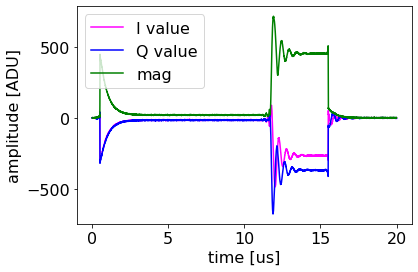

In [43]:
class ResTestProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
#                        mode='periodic',
                       freq=cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        
        # trigger the resonator and the DDR4 buffer
        self.trigger(ddr4=True, mr=True, t=0)
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        if cfg['do_jump']:
            self.trigger(pins=list(range(8,16)), t=cfg['t_jump'])
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

# do a sweep with 5 points and plot decimated
config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': 500.0,
          'nqz': 1,
          'trig_time': 3.0,
          'do_jump' : True,
          't_jump' : 12,
          'ro_len': 20,
          'pulse_len': 15,
          'phase': 0,
          'gain': 1.0,
#           'gain': 0.05,
         }

prog = ResTestProgram(soccfg, reps=1, final_delay=10.0, cfg=config)


# Arm the buffers
soc.arm_mr(ch=RO_CH)
n_transfers = 100000 # each transfer (aka burst) is 256 decimated samples
soc.arm_ddr4(ch=RO_CH, nt=n_transfers)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

iq=iq_list[0]
plt.plot(t, iq[:,0], label="I value", color="magenta")
plt.plot(t, iq[:,1], label="Q value", color="blue")
plt.plot(t, np.abs(iq.dot([1,1j])), label="mag", color="green")
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

```diff
+ Q. Change `t_jump`, `pulse_len`,`ro_len`, and `do_jump`. Also change `freq` to 499.0 and try that. Do the results match your expectation?

```

# We read a superconducting qubit out using the readout resonator that it is coupled to.

When a qubit decays from its excited state to its ground state, its readout resonator jumps back from “e”to “g” instantaneously at random times given by a Poisson distribution with a time scale set by the qubit’s T1 time. In the next lab, we will specify the amount of T1 decay we want.

```diff
+ Q. Look at what happens to I, Q and mag during these jumps. How does this correspond to a measurement of T1 decay? What would it look like for a qubit to undergo T1 decay after 12 us?
```